# Star Trek Script Generator

## Just want to make scripts?

* Run everything in the setup section
* Then go straight to generate scripts section, skipping the rest

## Want to train up the model?

* Run the whole notebook

## Thanks and Attributions

Based on [script_generation.ipynb](https://github.com/cdpierse/script_buddy_v2/blob/master/script_buddy/script_generation.ipynb)

## Setup


In [0]:
!pip -q install transformers

     |████████████████████████████████| 675kB 14.5MB/s 
     |████████████████████████████████| 1.1MB 55.3MB/s 
     |████████████████████████████████| 890kB 59.3MB/s 
     |████████████████████████████████| 3.8MB 57.9MB/s 


In [0]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup, AutoTokenizer, AutoModelWithLMHead
import numpy as np
import os
import random
from datetime import datetime
from IPython.display import clear_output
from time import sleep
from zipfile import ZipFile
# import subprocess
# from utils import *

In [0]:
# Clone repo with dataset

if not os.path.exists('trekbot'):
  os.mkdir('trekbot')
  !git clone https://github.com/alexcg1/trekbot_script-writer.git trekbot
else:
  %cd trekbot
  !git pull
  %cd ..

Cloning into 'trekbot'...
remote: Enumerating objects: 63, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 63 (delta 22), reused 53 (delta 12), pack-reused 0
Unpacking objects: 100% (63/63), done.


In [0]:
# Copy out includes
!cp trekbot/*.py .

In [0]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'

## Load Model

In [0]:
MODEL_NAME = 'alexcg1/trekbot'

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print(f"Loaded Tokenizer from {MODEL_NAME}")
model = AutoModelWithLMHead.from_pretrained(MODEL_NAME)
print(f"Loaded Model from {MODEL_NAME}")


Loaded Tokenizer from alexcg1/trekbot



Loaded Model from alexcg1/trekbot


In [0]:
model = model.to(device)

## Load Data

### Basic Settings

In [0]:
# How many episodes to train on? If 0, assume all episodes
EP_COUNT = 0

# Sample length for samples generated from model
SAMPLE_LENGTH = 1000
SAMPLE_COUNT = 12

### Load Dataset

In [0]:
from language_modelling import ScriptData
data_file = os.path.join("trekbot", "data", "film_text.txt")
dataset = ScriptData(file_path=data_file, tokenizer=tokenizer)

Creating features from file film_text.txt at .
Succesfully read text from file
Saving features into cached file ./gpt2_512_film_text.txt


In [0]:
if EP_COUNT != 0:
    print(f"Dataset size before: {len(dataset)}")
    dataset = dataset[:EP_COUNT]
    print(f"Dataset size after: {len(dataset)}")

In [0]:
from torch.utils.data import Dataset, DataLoader
script_loader = DataLoader(dataset, batch_size=1, shuffle=True)

In [0]:
len(script_loader)

6526

## Train Model

If you just want scripts, skip straight to the "Generating Samples" section

### Params and Hyperparams

* Batch size: How many things to process at once. Too high may crash notebook from memory usage
* Epochs: How many times to go over *all* the data
* Learning Rate: Lower = deeper learning, Higher = faster
* Warmup steps: Don't know how to explain this one

In [0]:
BATCH_SIZE = 3
EPOCHS = 1
LEARNING_RATE = 0.000000001
WARMUP_STEPS = 10000

In [0]:
FILENAME_SUFFIX = str(datetime.now())[:10]

# Filename for output scripts
SCRIPT_DIR = f"training-scripts/"
SCRIPT_FILENAME = f"scripts-{FILENAME_SUFFIX}.txt"

# Directory to save model
OUTPUT_MODEL_DIR = f"models/trekbot"
OUTPUT_MODEL_FILENAME = f"model.txt"

# This variable already used in code later
output_dir = OUTPUT_MODEL_DIR

In [0]:
from utils import Setup
dirs = ['models', SCRIPT_DIR, 'samples']

Setup.dir_setup(dirs) # Setup directory structure

Created models
Created training-scripts/
Created samples


In [0]:
model = model.to(device)
model.train() # Start training mode
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=WARMUP_STEPS, num_training_steps=-1)
script_count = 0
sum_loss = 0.0

In [0]:
total = len(dataset) # number of items in dataset

In [0]:
SAMPLE_INTERVAL = int(total/SAMPLE_COUNT)
# total_sample_count = floor(total/SAMPLE_INTERVAL)
print(f"Total samples: {SAMPLE_COUNT}")

Total samples: 12


In [0]:
start_time = datetime.now().strftime("%H:%M:%S")
print(f"Start: {start_time}")

Start: 23:23:38


In [0]:
from utils import Diag
# Setup diagnostics
losses = []
loss_log = "loss_rate.csv"

Diag.setup(loss_log)

Creating new log at loss_rate.csv


In [0]:
# Setup logging stuff

from statistics import mean
batch_count = 0
epoch_losses = []
mean_losses = []

In [0]:
for epoch in range(EPOCHS):
    epoch_loss = 0.0
    sum_losses = []
    for idx,script in enumerate(script_loader):
                
        outputs = model(script.to(device), labels=script.to(device))
        
        loss, logits = outputs[:2]
        timestamp = datetime.now().strftime("%H:%M:%S")
        
        loss.backward()

        sum_loss = sum_loss + loss.detach().data
                       
        script_count = script_count + 1
        if script_count == BATCH_SIZE:
            script_count = 0    
            batch_count += 1
            optimizer.step()
            scheduler.step() 
            optimizer.zero_grad()
            model.zero_grad()
        
        if batch_count == SAMPLE_INTERVAL:
            append_string = f"\t| Appending script to {SCRIPT_FILENAME}..."
        else:
            append_string = ''
        
        # Update output display
        clear_output(wait=True) # Clear and update display, otherwise endless scroll

        # Get data to display
        percent = round((idx/total)*100, 2)
        rounded_loss = round(float(loss.detach().data), 2)
        rounded_sum_loss = round(float(sum_loss), 2)
        losses.append(rounded_loss)
        epoch_loss += float(rounded_loss)
        
        # Deal with means
        cutoff = 100 # How many past losses do we sample for the average?
        neg_cutoff = cutoff*-1
        if len(mean_losses) < cutoff: # If we don't even have that many samples yet, just go with what we have
          mean_loss = round(mean(losses), 4)
        else:
          mean_loss = round(mean(losses[neg_cutoff:-1]), 4)
        mean_losses.append(mean_loss)

        # Display it
        print(f"{timestamp}\tEpoch {epoch+1}/{EPOCHS}\t Processing {idx}/{total} \t {percent}% \tMean Loss: {mean_loss} \tBatch:{batch_count} {append_string}")

        # Write to log file
        data = [timestamp, LEARNING_RATE, rounded_loss]
        Diag.write_row(data, loss_log)
        if batch_count == SAMPLE_INTERVAL:
            model.eval()
            # losses.append(sum_loss)
            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = SAMPLE_LENGTH,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )

            for i, sample_output in enumerate(sample_outputs):
                SCRIPT_PATH = os.path.join(SCRIPT_DIR, SCRIPT_FILENAME)
                with open(SCRIPT_PATH, "a") as file:
                    file.write("\n\n")
                    file.write("*" * 80)
                    file.write("\n\n")
                    file.write(tokenizer.decode(sample_output, skip_special_tokens=True))
                    print(f"Script appended to {SCRIPT_FILENAME}")
            
            batch_count = 0

            sum_losses.append(sum_loss)
            # sum_loss = 0.0
            model.train()
    epoch_losses.append(epoch_loss)

01:05:10	Epoch 1/1	 Processing 6525/13051 	 50.0% 	Mean Loss: 2.1901 	Batch:1 


In [0]:
end_time = datetime.now().strftime("%H:%M:%S")
print(f"Start: {start_time}")
print(f"End: {end_time}")

Start: 23:23:38
End: 01:05:10


In [0]:
# print(epoch_losses)
for idx, loss in enumerate(epoch_losses):
  # WHy /2? I think bc of dataset_batch_size (not training_batch_size) or something.
  # Hell if I know. Training stops successfully at what looks like 50% so whatever I'm printing as progress indicator is wrong
  print(f"Epoch {idx+1}:\t{round(epoch_loss/(total/2), 6)}") 

Epoch 1:	2.191585


### Analyze Training

You can skip this if you want. It just gives you an idea if the training is improving the loss rate or not. If things are going well, you should see a downward sloping graph

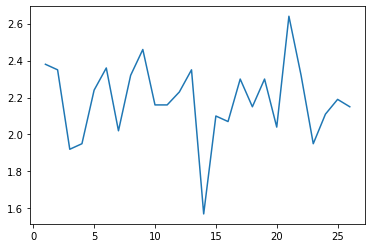

In [0]:
sample_every = 250
sampled_losses = []

counter = 0
for loss in losses:
  counter += 1
  if counter == sample_every:
    counter = 0
    sampled_losses.append(loss)

from matplotlib import pyplot as plt

y = np.array(sampled_losses)
x = []
i = 1
for point in y:
  x.append(i)
  i += 1

x = np.array(x)

plt.plot(x, y) # show raw data
plt.show()

### Save Trained Model

In [0]:
os.mkdir(OUTPUT_MODEL_DIR)

from transformers import WEIGHTS_NAME, CONFIG_NAME
output_model_file = os.path.join(OUTPUT_MODEL_DIR, WEIGHTS_NAME)
output_config_file = os.path.join(OUTPUT_MODEL_DIR, CONFIG_NAME)

torch.save(model.state_dict(), output_model_file)
print(f"Saved {output_model_file}")
model.config.to_json_file(output_config_file)
print(f"Saved {output_config_file}")
tokenizer.save_vocabulary(OUTPUT_MODEL_DIR)
print(f"Saved vocab.json to {OUTPUT_MODEL_DIR}")

Saved models/trekbot/pytorch_model.bin
Saved models/trekbot/config.json
Saved vocab.json to models/trekbot


## Download Trained Model

Download the model you've just trained

In [0]:
# Zip model
os.chdir(OUTPUT_MODEL_DIR)
files_to_add = ['merges.txt', 'config.json', 'vocab.json']
with ZipFile('model.zip', 'w') as zipObj:
  for filename in os.listdir():
    if filename in files_to_add:
      print(f"Adding {filename}")
      zipObj.write(filename)

print("model.zip created")

Adding merges.txt
Adding config.json
Adding vocab.json
model.zip created


In [0]:
# Get us back to working dir
%cd /content

/content


In [0]:
from google.colab import files
zip_path = os.path.join(OUTPUT_MODEL_DIR, 'model.zip')
files.download(zip_path)

KeyboardInterrupt: ignored

In [0]:
# This will download the big ass file
big_file_path = os.path.join(OUTPUT_MODEL_DIR, 'pytorch_model.bin')
files.download(big_file_path)

## Generate Samples

In [0]:
# Saved model will be used to generate samples
if os.path.exists("model"):
  model = GPT2LMHeadModel.from_pretrained(output_dir)
  tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
  print(f"Loaded model and tokenizer from {output_dir}")
else:
  print("Using downloaded model")

#### Top_p

* high temp - for asspulls.
* less temp - less random shit.
* top_p close to 0 = less creative AI
* top_p close to 1 = more random AI

But just go with 0.9 (default) as top_p (because is difficult to manage), and control randomness via temperature

[Source](https://github.com/VBPXKSMI/Open-CYOAI-Project/wiki/A-quick-explanation-on-what-is-top_k,-temp-and-top_p)


In [0]:
input_ids = tokenizer.encode('         He kisses her softly and takes out his gun.         ', return_tensors='pt')

In [0]:
sample_scripts = []

if not os.path.exists("samples"):
  os.mkdir("samples")

In [0]:
top_p = 0.9
def generate_sample(length):
  model.eval() # Turn on evaluation mode instead of training
  model.train() # Because eval brings up repetitive shit
  output = model.generate(
      input_ids=input_ids,
      num_beams=1,
      bos_token_id=random.randint(1,30000),
      do_sample=True,   
      top_k=50, 
      max_length = length,
      top_p=top_p, 
      num_return_sequences=1,
      )

  content = tokenizer.decode(output[0], skip_special_tokens=True)

  return content

In [0]:
SAMPLE_COUNT = 1
SAMPLE_LENGTH = 1200

for i in range(SAMPLE_COUNT):
  print(f"Generating script {i+1} of {SAMPLE_COUNT}")
  sample_script = generate_sample(SAMPLE_LENGTH)
  filename = f'script_{i+1:03}.txt'
  file_path = f'samples/{filename}'
  # with open(file_path, 'w') as file:
    # file.write(sample_script)
  print(f"{filename} written")
  print(sample_script)
  sample_scripts.append(sample_script)

In [0]:
# Save sample scripts
for i, script in enumerate(sample_scripts):
    filename = f'script_{i+1:03}.txt'
    file_path = f'samples/{filename}'
    with open(file_path, 'w') as file:
        file.write(script)
    print(f"{filename} written")

script_001.txt written
script_002.txt written
script_003.txt written


In [0]:
# Zip samples
os.chdir('samples')
with ZipFile('samples.zip', 'w') as zipObj:
    for filename in os.listdir():
        if not filename.endswith(".zip"):
            zipObj.write(filename)

print("samples.zip created")

samples.zip created


## Download Samples

In [0]:
from google.colab import files
files.download('/content/samples/samples.zip')